In [120]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
# from dask.distributed import Client
# import joblib

In [121]:
# client = Client(processes=False)             # create local cluster

In [122]:
pd.set_option('display.max_columns', None)

In [123]:
df_ny = pd.read_parquet('../data/ML_Data/NY',  engine='pyarrow')
df_fl = pd.read_parquet('../data/ML_Data/FL',  engine='pyarrow')
df_ca = pd.read_parquet('../data/ML_Data/CA', engine='pyarrow')
df_tx =pd.read_parquet('../data/ML_Data/TX', engine='pyarrow')
energy_df = pd.read_parquet('../data/energy_generation.parquet', engine='pyarrow')

In [124]:
df_ny['weekend'] = np.where(df_ny['days'].isin([0,7]), 1, 0)
df_tx['weekend'] = np.where(df_tx['days'].isin([0,7]), 1, 0)
df_ca['weekend'] = np.where(df_ca['days'].isin([0,7]), 1, 0)
df_fl['weekend'] = np.where(df_fl['days'].isin([0,7]), 1, 0)

In [125]:
energy_df['respondent'].value_counts()

FLA     68880
NYIS    68875
ERCO    68827
CISO    68736
Name: respondent, dtype: int64

In [126]:
energy_df = energy_df.set_index('period')
energy_df.index = pd.to_datetime(energy_df.index)

In [127]:
respondents = ['ERCO' ,
            'NYIS',
            'FLA' ,
            'CISO',]

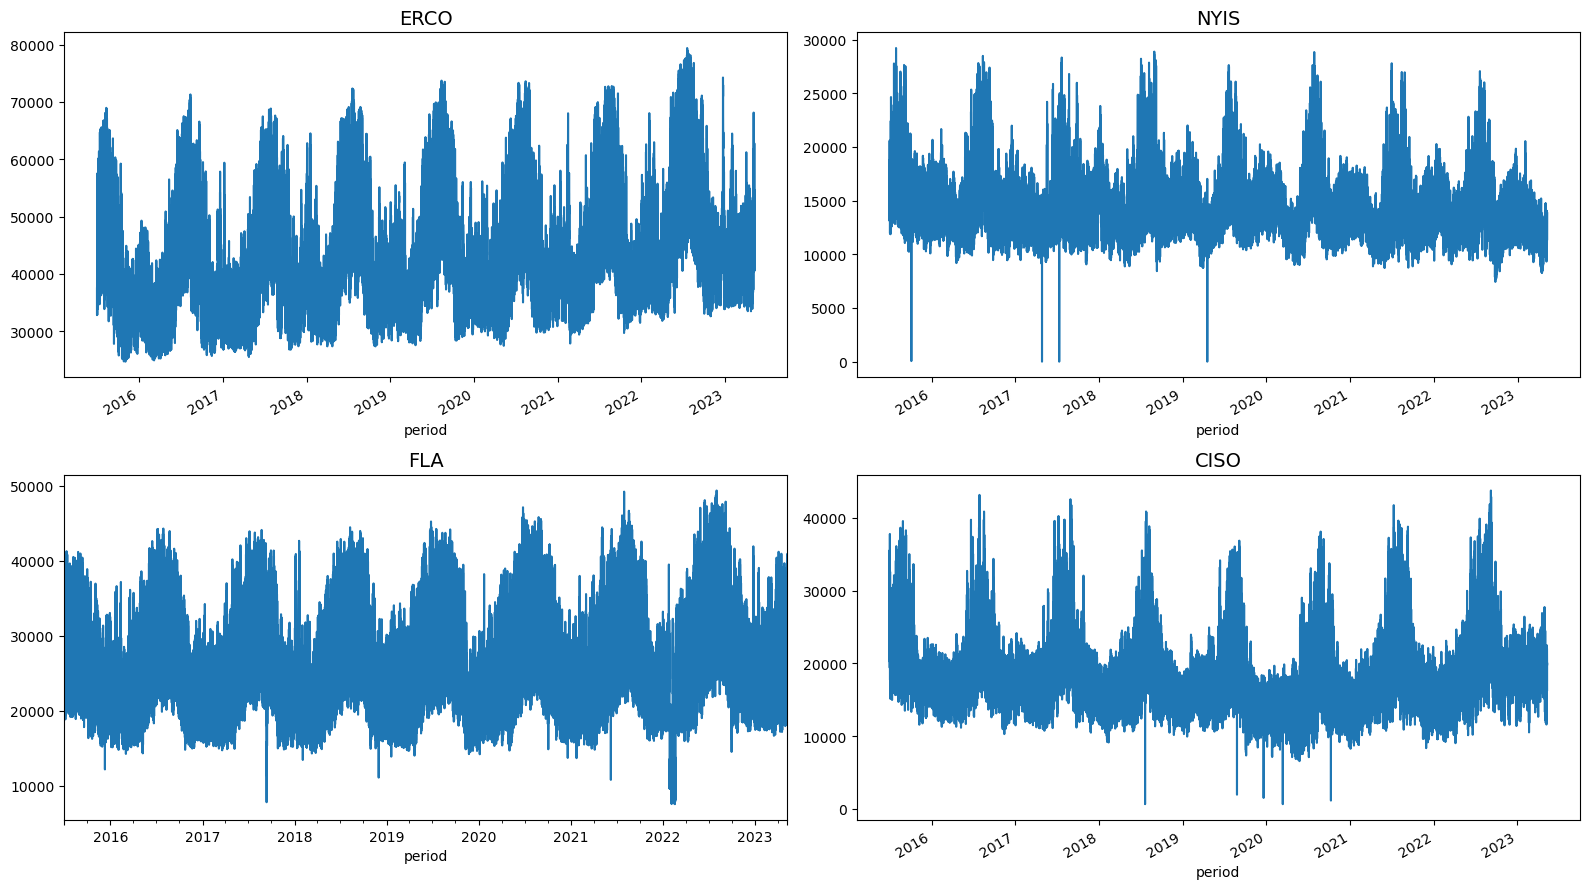

In [128]:
for n,res in enumerate(respondents):
    ax = plt.subplot(2,2,n+1)
    energy_df.query(f"respondent == '{res}' ")['value'].plot(ax = ax, figsize=(16,9))
    ax.set_title(label =f'{res}', fontsize =14)
    plt.tight_layout()

In [129]:
TARGET = 'value'
FEATURES = df_ny.columns[2:]

In [130]:
# train = df_tx.loc[df_tx.index <= '01-01-2021']
# test = df_tx.loc[df_tx.index >= '01-01-2021']
# X_train = train[FEATURES]
# y_train = train[TARGET]
# X_test = test[FEATURES]
# y_test = test[TARGET]

In [131]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 1100, stop = 1400, num = 8)]
# # Number of features to consider at every split
# max_features = ['auto']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(7, 18, num = 7)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [5, 7, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [2, 3, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True]
# warm_start = [True, False]
# oob_score = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap,
#                'oob_score' : oob_score,
#                'warm_start' : warm_start,
#                }

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()

In [132]:
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=3, n_jobs = -1)# Fit the random search model
# # rf_random.fit(X_train, y_train)
# with joblib.parallel_backend('dask'):
#     rf_random.fit(X_train, y_train)
# print(rf_random.best_params_)

{'warm_start': True, 'oob_score': True, 'n_estimators': 1185, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 12, 'bootstrap': True}

In [133]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [9, 11, 13],
#     'max_features': ['auto'],
#     'min_samples_leaf': [2, 3, 4],
#     'min_samples_split': [2, 3],
#     'n_estimators': [1000, 1100, 1200, 1300],
#     'oob_score' : [True],
#     'warm_start' : [True],
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [134]:
# with joblib.parallel_backend('dask'):
#     grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 1100, 'oob_score': True, 'warm_start': True}

In [147]:
def rand_tree_train(df, week):
    tss = TimeSeriesSplit(n_splits=3, test_size=24*547, gap=24)
    df = df.sort_index()
    fold = 0
    preds = []
    scores_rmse = []
    scores_mae = []
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]
        regr = RandomForestRegressor( # criterion='squared_error',
                            n_estimators = 1185,
                            min_samples_split = 3,
                            # min_samples_leaf = 3,
                            max_features= 'sqrt',
                            max_depth = 12,
                            # bootstrap= True, 
                            random_state = 7,
                            # oob_score= True,
                            warm_start= True,
                            n_jobs=-1,                      
                            )
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        preds.append(y_pred)
        score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores_rmse.append(score_rmse)
        scores_mae.append(mean_absolute_error(y_test,y_pred))
    print(f'Score across folds(mse): {np.mean(scores_rmse):0.4f}')
    print(f'Fold scores(mse):{scores_rmse}')
    print(f'Score across folds(mae): {np.mean(scores_mae):0.4f}')
    print(f'Fold scores(mae):{scores_mae}')
    if week is None:
        week = ['03-01-2023', '03-07-2023']
    test['prediction'] = regr.predict(X_test)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = df[['value']].plot(figsize=(15, 6))
    df['prediction'].plot(ax=ax, style='.')
    plt.legend(['Actual', 'Predicted'],loc='upper right')
    ax.set_title('Actual VS. Predicted')
    plt.show()
    
    ax = df.loc[(df.index > week[0]) & (df.index < week[1])]['value'] \
    .plot(figsize=(15, 6), title='Week Of Data')
    df.loc[(df.index > week[0]) & (df.index < week[1])]['prediction'] \
        .plot()
    plt.legend(['Actual','Predicted'],loc='upper right')
    plt.show()
    # print(df.head())
    return regr, X_test, test

In [148]:
# def create_graphs(df, X_test,test, week=None):
#     if week is None:
#         week = ['12-20-2022', '12-27-2022']
#     test['prediction'] = regr.predict(X_test)
#     df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
#     ax = df[['value']].plot(figsize=(15, 6))
#     df['prediction'].plot(ax=ax, style='.')
#     plt.legend(['Actual', 'Predicted'],loc='upper right')
#     ax.set_title('Actual VS. Predicted')
#     plt.show()


#     ax = df.loc[(df.index > week[0]) & (df.index < week[1])]['value'] \
#     .plot(figsize=(15, 6), title='Week Of Data')
#     df.loc[(df.index > week[0]) & (df.index < week[1])]['prediction'] \
#         .plot()
#     plt.legend(['Actual','Predicted'],loc='upper right')
#     plt.show()

In [149]:
def create_importance(regr):
    fi = pd.DataFrame(data = regr.feature_importances_[:15],
    index = regr.feature_names_in_[:15],
    columns = ['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance',)
    plt.show()

In [150]:
def run_model(df, week_list=None):    
    if week_list == None:
        week = ['03-01-2023', '03-07-2023']
    else:
        week = week_list
    regr, X_test, test = rand_tree_train(df, week)
    # create_graphs(df,X_test=X_test, test=test, week=week)
    create_importance(regr)

Score across folds(mse): 5538.2560
Fold scores(mse):[5079.644690965931, 5087.371624946288, 6447.751770783205]
Score across folds(mae): 4095.7165
Fold scores(mae):[3771.5742291869506, 3786.995152222651, 4728.580256434671]


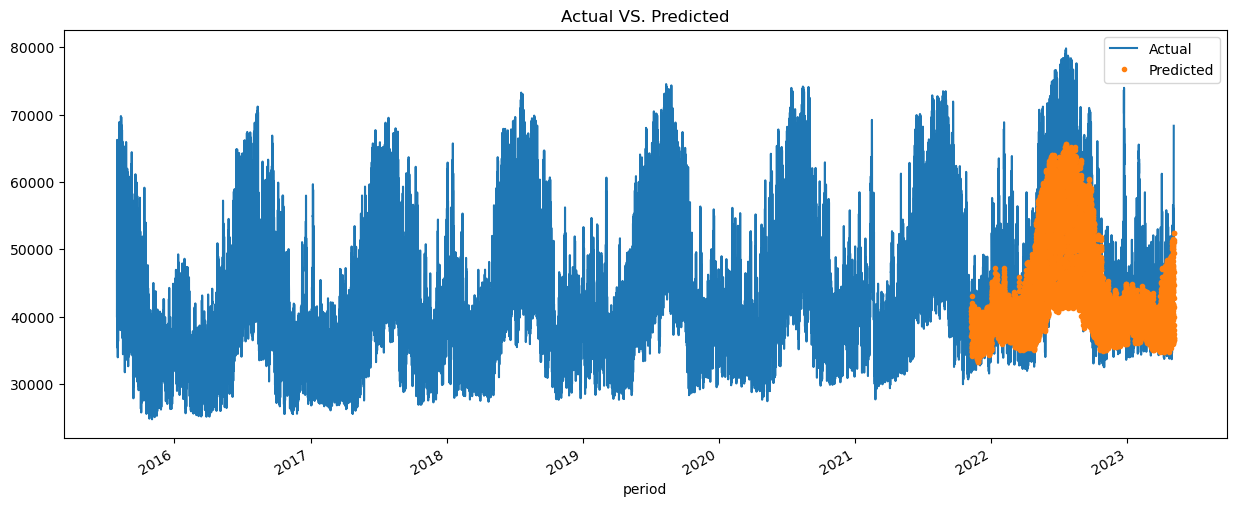

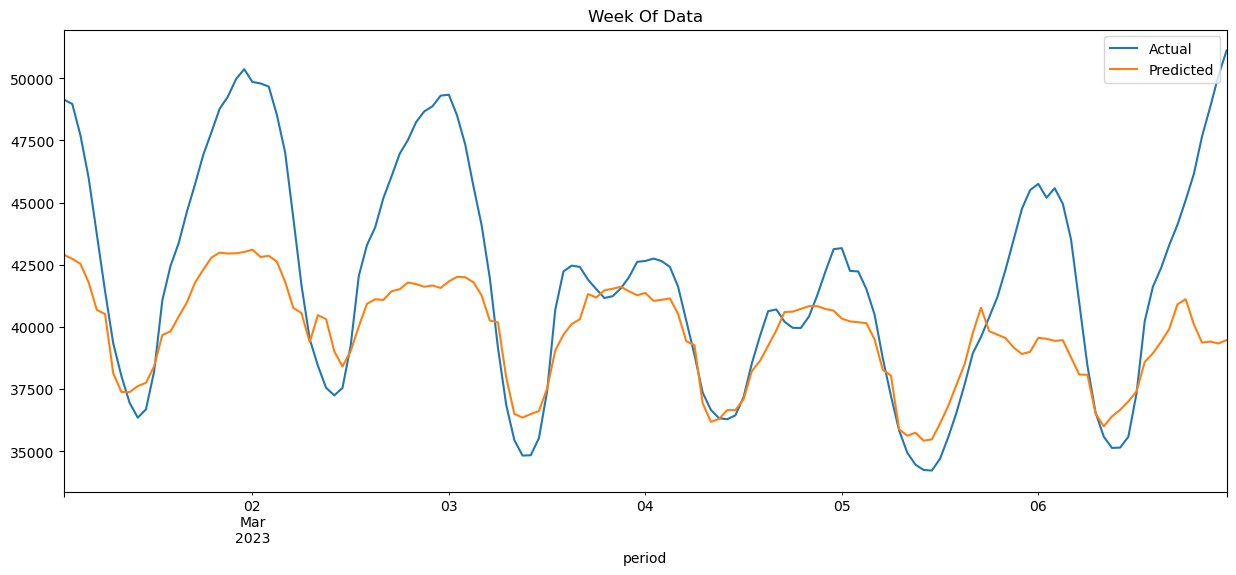

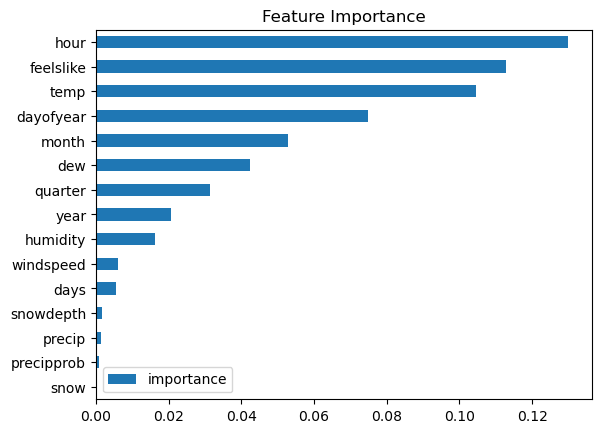

In [151]:
mod_tx = run_model(df_tx)

Score across folds(mse): 1393.7548
Fold scores(mse):[1414.930188819858, 1558.0869811728035, 1208.2471921181966]
Score across folds(mae): 1105.2767
Fold scores(mae):[1139.7403430115658, 1196.951893094833, 979.1377378813413]


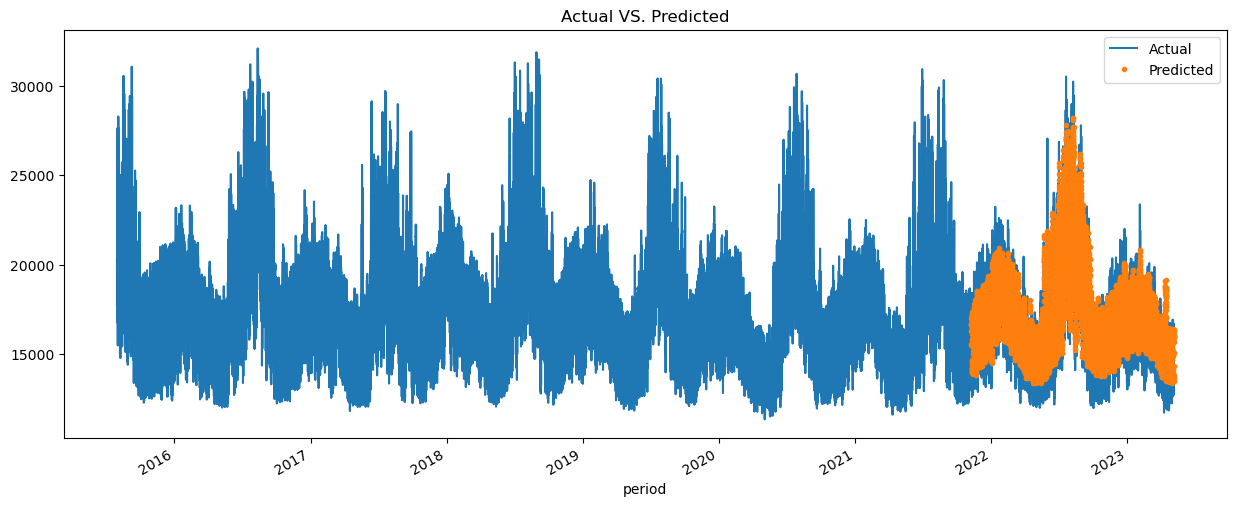

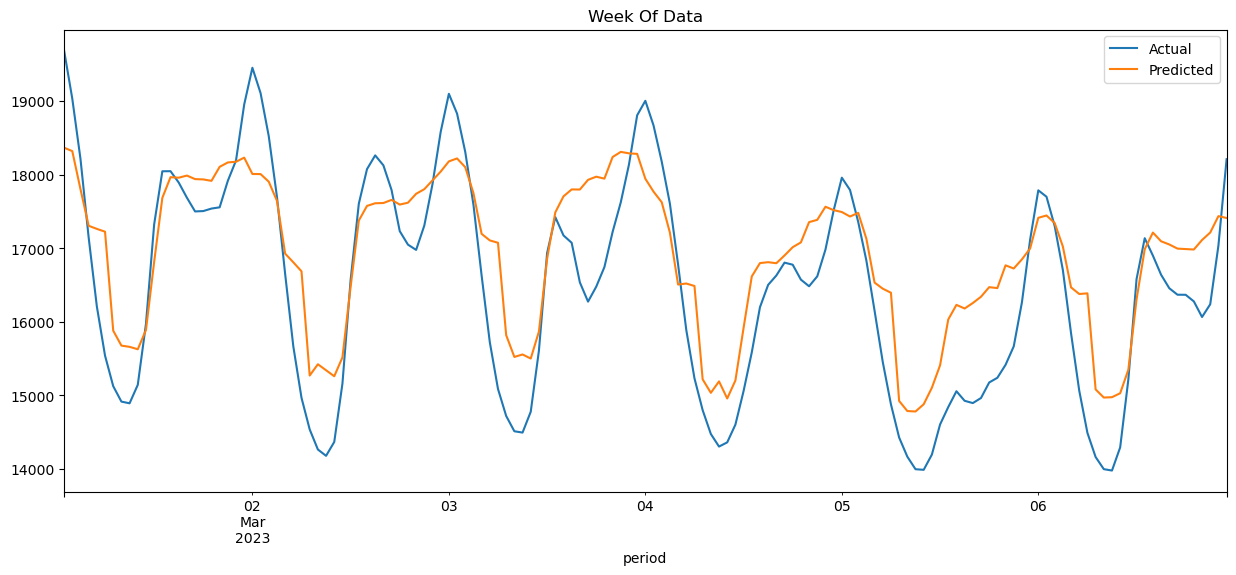

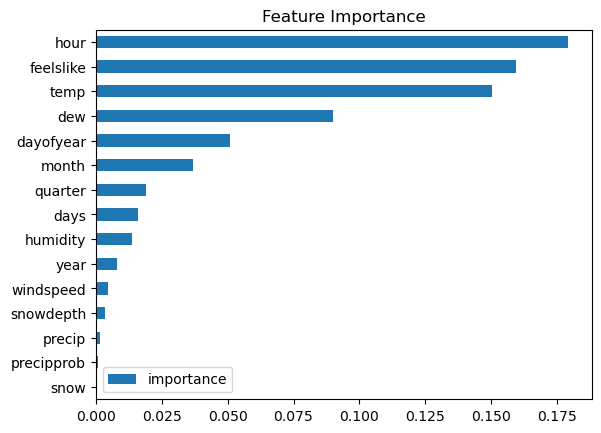

In [152]:
mod_ny = run_model(df_ny)

Score across folds(mse): 3036.5380
Fold scores(mse):[2862.279153460879, 2976.0398194048794, 3271.2949733467067]
Score across folds(mae): 2366.6710
Fold scores(mae):[2249.7283034898896, 2330.5402695333178, 2519.7445290301976]


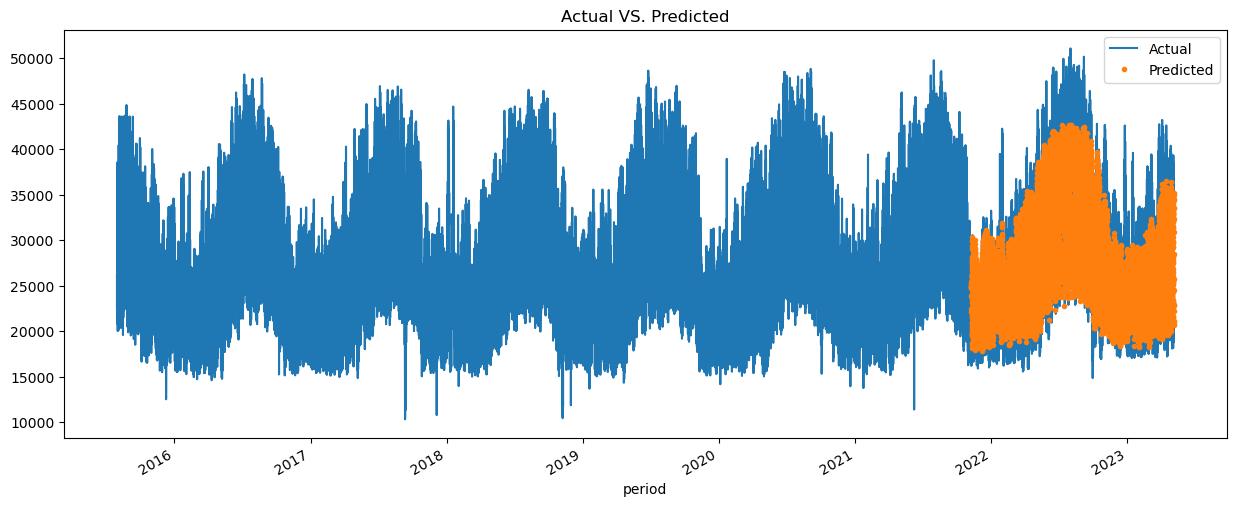

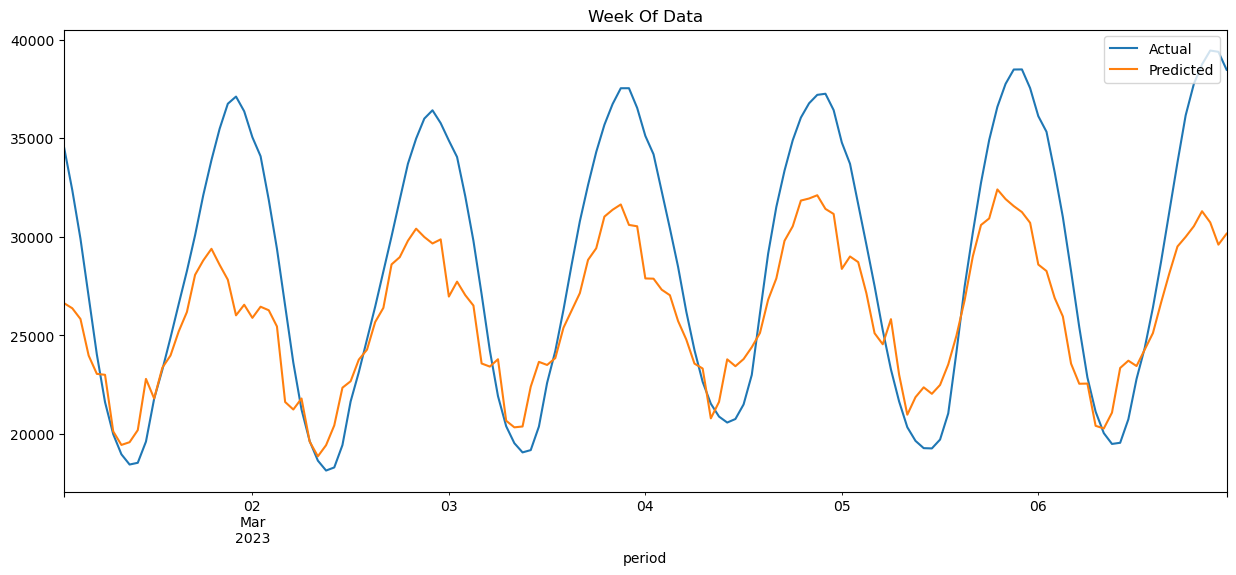

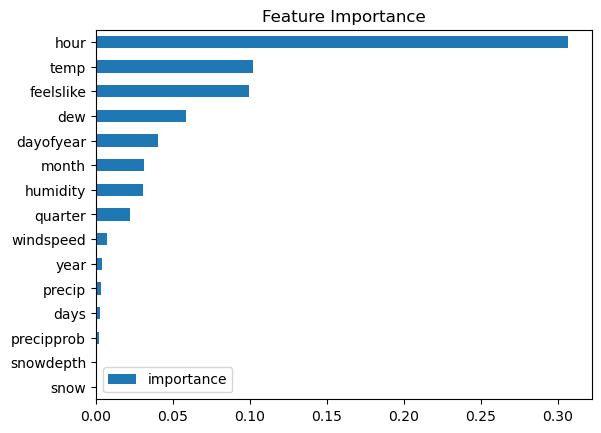

In [153]:
mod_fl = run_model(df_fl)

Score across folds(mse): 2329.9245
Fold scores(mse):[2617.9206485662735, 2222.5890136319063, 2149.263774172757]
Score across folds(mae): 1761.2399
Fold scores(mae):[2073.525937778924, 1629.6379238911666, 1580.5558311027726]


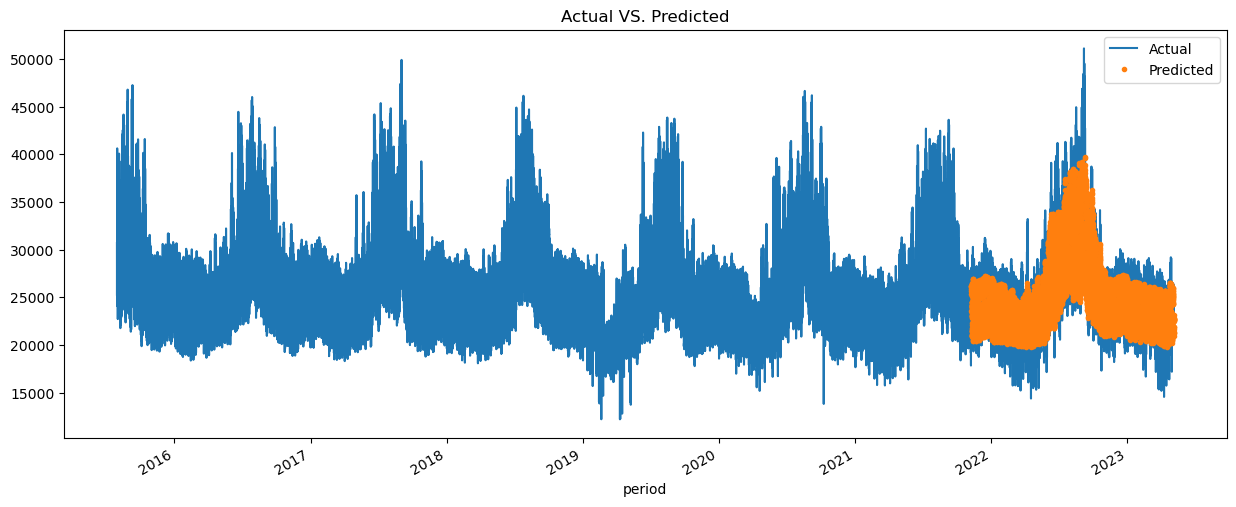

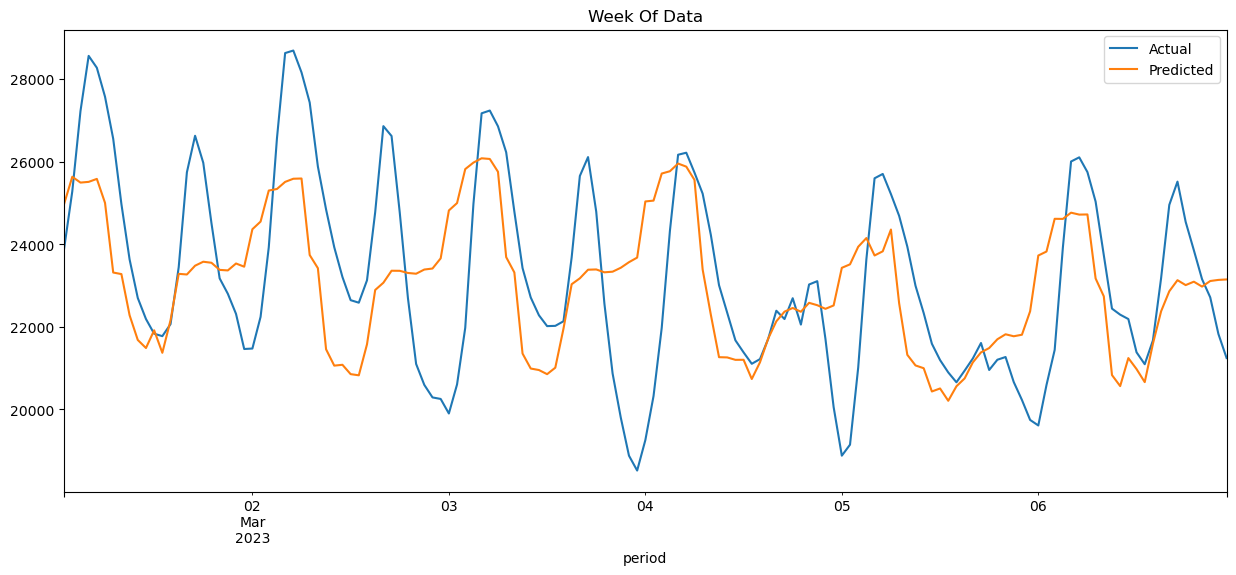

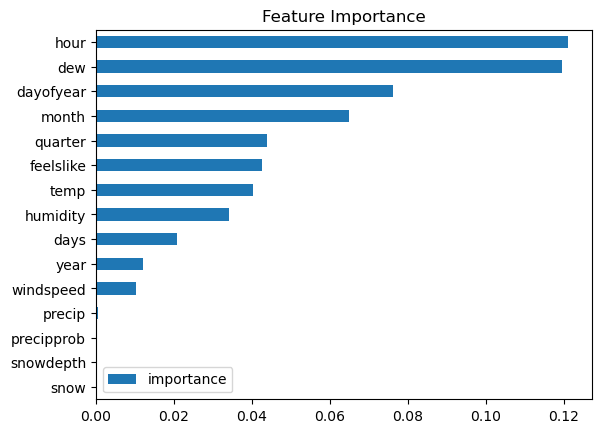

In [154]:
mod_ca = run_model(df_ca)